# Model proto

This is a rough prototype of our RL solution

In [12]:
import os
if os.getcwd() == '/kaggle/working':
    import sys
    
    !rm -rf 'PMLDL-Project'
    !git clone -b main https://github.com/Sambura/PMLDL-Project
    
    if 'PMLDL-Project' not in sys.path: sys.path.append('PMLDL-Project')

    %pip install dice

In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import time
import sys
import os

if '..' not in sys.path: sys.path.append('..')

from src.utils.common import *
from src.utils.plot_utils import *
from src.dnd.actions import *
from src.dnd.units import *
from src.dnd.game_utils import *
from src.agent.agent import DnDAgent
from src.agent.deep_q_network import *
from src.agent.agent_utils import get_legal_action_resolver, get_states, agents_play_loop
from src.agent.training import *
from src.dnd.game_configs import *

In [15]:
seed_everything(1234, deterministic_cudnn=True)

## Sample agent game

In [16]:
board_size, game_config = get_2v2_1_config()

In [17]:
yi, xi = np.meshgrid(np.arange(board_size[0]), np.arange(board_size[1]), indexing='ij')

def dnd_legal_moves_masker(state, ch_count, board_size):
    remaining_speed = state[11, 0, 0]

    current_unit_pos = np.where(state[2] != 0)
    y, x = current_unit_pos[0][0], current_unit_pos[1][0]        
    distance = np.abs(yi - y) + np.abs(xi - x)

    attack_range = state[4, y, x]
    possible_targets = np.where(np.logical_and(state[1], distance <= attack_range))

    occupied = np.logical_or(state[0], state[1])
    possible_positions = np.where(np.logical_and(distance <= remaining_speed, occupied == 0))

    mask = np.zeros((ch_count, *board_size), dtype=np.bool_)

    mask[0, possible_positions[0], possible_positions[1]] = 1
    mask[1, possible_targets[0], possible_targets[1]] = 1
    if ch_count > 2: mask[2, 0, 0] = 1

    return mask

In [18]:
def calculate_reward_classic_seq(game, game_state, unit: Unit, player_id: int, move_legal: bool, action_legal: bool, updates: dict):
    reward = 0

    if move_legal is not None: # agent (tried) to move
        if not move_legal: return reward

        units_removed = updates['units_removed'] # only possible if move_legal == True

        # penalty for killing yourself
        if len(game.players_to_units[player_id]) == 0:
            reward -= 15

        return reward
    elif action_legal is not None: # agent (tried) to invoke action
        if not action_legal: return reward

        units_removed = updates['units_removed'] # only possible if action_legal == True

        # reward for winning
        if len(game.players_to_units[player_id]) == len(game.units):
            return 15

        return len([x for x in units_removed if x[1] != player_id])
    else:
        return -1
    
    # agent passed
    return reward

In [19]:
agent = DnDAgent(board_shape=board_size, in_channels=DnDBoard.STATE_CHANNEL_COUNT, out_actions=2, 
    lr=1e-3, 
    epsilon=0.5, 
    min_epsilon=0.05,
    epsilon_delta=2e-5, 
    epsilon_strategy='exp',
    gamma=0.99,
    batch_size=32, 
    dual_learning=True,
    replace_model_interval=10000,
    memory_capacity=100000,
    random_action_resolver=get_legal_action_resolver(board_size, False),
    model_class=DnDEvalModelRT5,
    sequential_actions=False,
    legal_moves_masker=dnd_legal_moves_masker
)

train_loop = train_loop_trivial
reward_policy = calculate_reward_classic

In [20]:
games = 50000
checkpoint_interval = 4000
game_iter_limit = 2500
average_result_over = 1000

# set to None to disable report / figures export
output_path = '../rnd/'
generation_name = '_temp'
gen_header = \
'''# New field generation test

'''

In [21]:
iters, eps, checkpoints, reps = [], [], [], []
mag1s, mag2s, mag3s = [], [], []
memory_cap_iter = None

did_replace = [ False ]
def on_replace():
    global did_replace
    did_replace[0] = True
    
agent.on_replace = on_replace
gen = fieldGenerator(board_size=board_size).load_from_folder('../Tokens')

report_results = output_path is not None
if report_results:
    gen_path = os.path.join(output_path, generation_name)
    os.makedirs(gen_path, exist_ok=generation_name.startswith('_temp'))
else: gen_path = '..' # so that checkpoints still work

In [22]:
last_update = time.time()

last_checkpoint = checkpoints[-1] if len(checkpoints) > 0 else 0
with tqdm(range(games), desc='Training', smoothing=0.1) as pbar:
    for i in pbar:
        game = generate_balanced_game(board_size, game_config)
        
        outputs = agent.predict(game.observe_board())
        metric = np.mean(np.abs(outputs), axis=(1, 2))
        mag1s.append(metric[0])
        mag2s.append(metric[1])
        # mag3s.append(metric[2])
        pbar.set_postfix({'mag1': metric[0], 'mag2': metric[1]})

        iter_count = train_loop(agent, game, reward_policy, iter_limit=game_iter_limit, raise_on_limit=False)
        iters.append(iter_count)
        eps.append(agent.epsilon)

        iter_i = len(iters)
        ctime = time.time()
        if ctime - last_update > 20:
            if agent.memory_bound == agent.memory_capacity and memory_cap_iter is None:
                memory_cap_iter = iter_i
            clear_output(wait=True)
            ax, ax2 = plot_training_history(iters, eps, checkpoints, vlines=reps, min_ymax=30, average_last=average_result_over, show=False)
            if memory_cap_iter is not None: ax.axhline(memory_cap_iter, c='b')
            plt.show()
            if hasattr(pbar, 'container'): display(pbar.container)
            last_update = ctime

        if iter_i - last_checkpoint >= checkpoint_interval:
            last_checkpoint = iter_i
            checkpoints.append(iter_i)
            avg = np.mean(iters[-average_result_over:]) # recent performance
            agent.save_agent(os.path.join(gen_path, f'checkpoints/agent-{avg:0.1f}i-{iter_i / 1000:0.1f}k'))

        if did_replace[0]:
            did_replace[0] = False
            reps.append(iter_i)

Training:   0%|          | 0/50000 [00:00<?, ?it/s]

C:\Users\Admin\AppData\Local\Temp\ipykernel_19504\3097871705.py:6: DeprecationWarning: generate_balanced_game is now performed through `fieldGenerator` class
  game = generate_balanced_game(board_size, game_config)


In [ ]:
plot_training_history(iters, eps, checkpoints, vlines=reps, min_ymax=20, figsize=(20, 10), show=False)
if report_results:
    plt.savefig(os.path.join(gen_path, 'training.png'), bbox_inches='tight')
plt.show()

In [ ]:
plt.plot(mag1s, label='coords')
plt.plot(mag2s, label='action')
# plt.yscale('log')
plt.legend()
if report_results:
    plt.savefig(os.path.join(gen_path, 'magnitude.png'), bbox_inches='tight')
plt.show()
print(f'Total number of iterations: {np.sum(iters)}')

In [ ]:
if report_results:
    actual_games = len(iters)

    with open(os.path.join(gen_path, 'report.md'), 'w') as report:
        avg = np.mean(iters[-1000:])
        total = np.sum(iters)
        perf = 1e9 / (avg * total)
        report.write(
f'''{gen_header}
# Results
![image](training.png "")

* Average iteration count after {actual_games / 1000:0.1f}k games: {avg:0.2f}
* Total iterations performed: {total}
* Relative training performance: {perf:0.2f}
> 1e9 / (total_iter * avg_iter)

## Model's outputs magnitude history:

![magnitudes](magnitude.png "")

# Configuration

```python


games = {actual_games}
```
''')

In [ ]:
print(f'Shortest game: {np.min(iters)}')
print(f'Longest game: {np.max(iters)}')
print(f'Number of shortest games: {np.sum(np.array(iters) == np.min(iters))}')

In [ ]:
seed_everything(0, True)
gen.reset()
game, colormap = decorate_game(generate_balanced_game(board_size, game_config))

agents_play_loop([agent, agent], game, colormap, reset_epsilon=True, delay=2)

Iteration: 1
	Unit moves: (6, 6) -> (6, 5) [successful];
	Unit takes aciton `Sword attack` with attributes: {'source_unit': 'Ally soldier', 'target_unit': 'None'} [not successful];
Units alive: 4
Players: 2:
	Player #0 (2 units): `Ally soldier (100 HP)`, `Ally archer (50 HP)`  
	Player #1 (2 units): `Enemy soldier (100 HP)`, `Enemy archer (50 HP)`  
	
    0 1 2 3 4 5 6 7
 0         ██       0 
 1                  1 
 2                  2 
 3                  3 
 4               ██ 4 
 5                  5 
 6           ██     6 
 7             ██   7 
    0 1 2 3 4 5 6 7

Next move is by player #0: `Ally archer`

Game interrupted after 2 iterations


# Visualization

In [ ]:
gen.reset()
game, colormap = decorate_game(generate_balanced_game(board_size, game_config))
print_game(game, colormap)

Units alive: 4
Players: 2:
	Player #0 (2 units): `Ally soldier (100 HP)`, `Ally archer (50 HP)`  
	Player #1 (2 units): `Enemy soldier (100 HP)`, `Enemy archer (50 HP)`  
	
    0 1 2 3 4 5 6 7
 0                  0 
 1       ████       1 
 2                  2 
 3             ██   3 
 4                  4 
 5               ██ 5 
 6                  6 
 7                  7 
    0 1 2 3 4 5 6 7

Next move is by player #0: `Ally archer`


C:\Users\Admin\AppData\Local\Temp\ipykernel_1340\2948519050.py:2: DeprecationWarning: generate_balanced_game is now performed through `fieldGenerator` class
  game, colormap = decorate_game(generate_balanced_game(board_size, game_config))


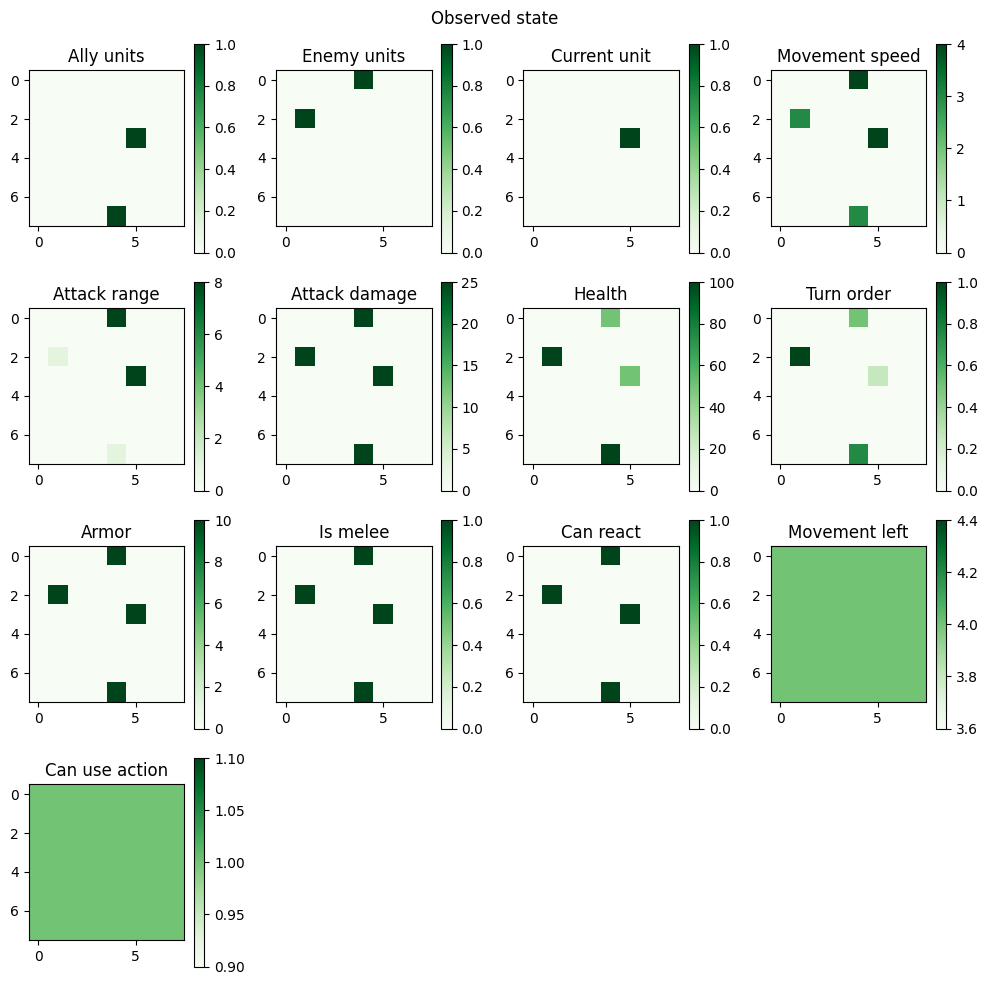

In [ ]:
state = game.observe_board()
plot_featuremaps(
    state, 
    title='Observed state', 
    fm_names=game.CHANNEL_NAMES,
    vmin = -3,
    vmax = 3,
    separate_cbars=True,
    cmap='Greens'
)

In [ ]:
agent.epsilon = 0

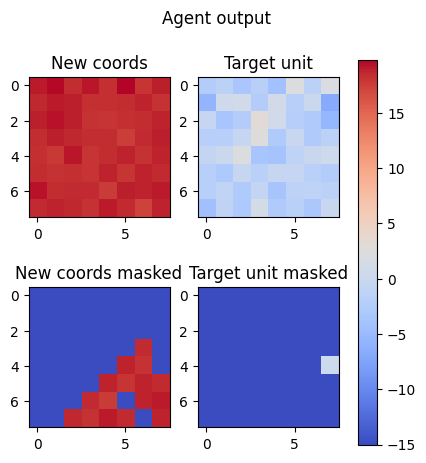

(array([7, 4], dtype=int64), array([4, 7], dtype=int64))
['(7, 4)', "Sword attack: {'source_unit': 'Ally archer', 'target_unit': 'Enemy archer'}"]


In [ ]:
state = game.observe_board()
output = agent.predict(state)
mask = agent.legal_moves_masker(state, 2, (8, 8))
output_m = agent.apply_mask(np.copy(output), mask)

plot_featuremaps(
    np.array([*output, *output_m]), 
    title='Agent output', 
    fm_names=['New coords', 'Target unit', 'New coords masked', 'Target unit masked'],
    separate_cbars=False
)

av = agent.choose_action_vector(state)
print(av)
from src.agent.agent_utils import decode_action
print([str(x) for x in decode_action(game, av)])